In [215]:

from polygon import RESTClient
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time



def calculate_ema(data, period):
  return data.ewm(span=period, adjust=False).mean()

def calculate_macd(data):
  ema_12 = calculate_ema(data, 12)
  ema_26 = calculate_ema(data, 26)
  macd_line = ema_12 - ema_26
  signal_line = calculate_ema(macd_line, 9)
  return macd_line, signal_line

def generate_date_array(year):
    dates = []
    # Start from the first day of the given year
    current_date = datetime(year, 1, 1)
    # End on the last day of the given year
    end_date = datetime(year + 1, 1, 1)
    
    while current_date < end_date:
        # Format the date as "yyyy-mm-dd" and add it to the list
        date_string = current_date.strftime("%Y-%m-%d")
        dates.append(date_string)
        # Move to the next day
        current_date += timedelta(days=1)
    
    return dates

def graph_profits(data, type_of_profit):
    # Extract keys and values
    dates = list(data.keys())
    values = list(data.values())

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', linestyle='-', color='b')

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    # Label the axes
    plt.xlabel('Date')
    plt.ylabel(type_of_profit)
    plt.title(f'Model {type_of_profit} vs Holding Stock')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

def graph_transactions(transactions):
  # Convert transactions to a DataFrame for easier manipulation
  df = pd.DataFrame(transactions, columns=['Date', 'Price', 'Type'])

  # Convert the 'Date' column to datetime objects
  df['Date'] = pd.to_datetime(df['Date'])

  # Separate the transactions by type
  sell_transactions = df[df['Type'] == 'Sell']
  buy_transactions = df[df['Type'] == 'Buy']

  # Plotting
  plt.figure(figsize=(6, 4))

  # Plot sell transactions in red
  plt.scatter(sell_transactions['Date'], sell_transactions['Price'], color='red', label='Sell', marker='x')

  # Plot buy transactions in green
  plt.scatter(buy_transactions['Date'], buy_transactions['Price'], color='green', label='Buy', marker='o')
  
  

  # Labels and title
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Transaction Prices Over Time')
  plt.legend()

  # Format the date on the x-axis
  plt.gcf().autofmt_xdate()

  # Show the plot
  plt.show()


def get_data(ticker, start_date, end_date):
    client = RESTClient("InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d")
    aggs = client.get_aggs(ticker, 1, "day", start_date, end_date, limit=50000)
    print("Number of Data Points:",len(aggs))
    return aggs

In [216]:
def run_simulation(ticker, start_date, end_date, init_cash, init_shares, percent_invest, prices, times, buys, sells):
  transaction_times = sorted(buys + sells)
  transactions = []
  for t in transaction_times:
    price = prices[times.index(t)]
    if t in buys:
      transactions.append([t, price, "Buy"])
    else:
      transactions.append([t, price, "Sell"])
  
  # print("Transactions: ", transactions)
  graph_transactions(transactions)
  # Execute Transactions through simulation
  cash = init_cash
  shares = init_shares
  print("Running Simulation for MACD with", ticker, "from", start_date, "to", end_date)
  print("Number of Transactions: ", len(transactions))
  print("Buys: ", len(buys), "Sells: ", len(sells))
  print("Open Price, Close Price: ", prices[0], prices[-1])
  print("Beginning Cash and Shares: ", cash, shares)
  portfolio_val_s = cash + prices[0] * shares
  print("Beginning Portfolio Value: ", portfolio_val_s)
  amt = cash * percent_invest / 100
  for order in transactions:
    if order[2] == "Buy":
      cash -= amt
      shares += amt/order[1]
    else:
      cash += amt
      shares -= amt/order[1]
  print("End Cash and Shares: ", cash, shares)
  portfolio_val_e = cash + prices[-1] * shares
  profit = portfolio_val_e - portfolio_val_s
  profit_percentage = (portfolio_val_e - portfolio_val_s) / portfolio_val_s * 100

  base_profit_percentage = init_shares*(prices[-1]-prices[0])/portfolio_val_s * 100

  print("End Portfolio Value: ", portfolio_val_e)
  print()
  print("Model Profit Percentage: ", profit_percentage)
  print("Market Change w/o trades", base_profit_percentage)
  print()
  print("Model outperforms market by", (profit_percentage - base_profit_percentage), "%") 


  return [cash, shares, profit, profit_percentage, base_profit_percentage]

In [217]:
def invest_macd(ticker, data, start_date, end_date, cash=100000, shares=1000, percent_invest=20):
  aggs = data
  timestamps = []
  close_prices = []
  for agg in aggs:
    timestamps.append(datetime.fromtimestamp(agg.timestamp // 1000))
    close_prices.append(agg.close)
  close_prices = np.array(close_prices)
  x_close = []
  y_close = []
  for i in range(0, len(aggs), 1):
    agg = aggs[i]
    x_close.append(datetime.fromtimestamp(agg.timestamp // 1000).strftime("%Y-%m-%d %H:%M"))
    y_close.append(agg.close)

  #check if there is data for this day
  # print(len(y_close))
  if len(y_close) == 0:
    print(f"no data for this day {start_date} and stock")
    return(cash, shares, 0, 0, 0)
  
  # Convert close prices to Pandas Series
  close_series = pd.Series(close_prices)
  # Calculate MACD and Signal line
  macd_line, signal_line = calculate_macd(close_series)
  # Calculate short-term EMAs

  # ema_12 = calculate_ema(close_series, 12)

  # ema_26 = calculate_ema(close_series, 26)
  #   # Plot closing prices (debug):
    
  # plt.figure(figsize=(7, 5))
  # plt.plot(timestamps, close_prices, label='Close Prices')
  # # plt.plot(timestamps, ema_5, label='5-period EMA', linestyle='--')
  # # plt.plot(timestamps, ema_10, label='10-period EMA', linestyle='--')
  # plt.plot(timestamps, ema_12, label='12-period EMA', linestyle='--')
  # plt.plot(timestamps, ema_20, label='20-period EMA', linestyle='--')
  # plt.plot(timestamps, ema_26, label='26-period EMA', linestyle='--')
  # plt.title('Closing Prices and Short-term EMAs')
  # plt.legend()
  # plt.show()
  plt.figure(figsize=(10, 4))
  plt.plot(timestamps, macd_line, label='MACD Line', color='blue')
  plt.plot(timestamps, signal_line, label='Signal Line', color='red')

  buys = []
  sells = []
  # Highlight crossovers (debug)
  for i in range(1, len(macd_line)):
    if (macd_line[i-1] < signal_line[i-1]) and (macd_line[i] > signal_line[i]) and (macd_line[i-1]-signal_line[i-1])<-.01:
      plt.axvline(x=timestamps[i], color='green', linestyle='--', linewidth=0.5)  # Bullish crossover
      buys.append(x_close[i])
    elif (macd_line[i-1] > signal_line[i-1]) and (macd_line[i] < signal_line[i]) and (macd_line[i-1]-signal_line[i-1])>.01:
      plt.axvline(x=timestamps[i], color='red', linestyle='--', linewidth=0.5)  # Bearish crossover
      sells.append(x_close[i])
      
  plt.title('MACD and Signal Line with Crossovers')
  plt.legend()

  plt.show()

  return run_simulation(ticker, start_date, end_date, cash, shares, percent_invest, y_close, x_close, buys, sells)   


In [218]:

def test_model(ticker, data, start_date, end_date, init_cash, init_shares, percent_invest):
    year1 = int(start_date[:4])
    year2 = int(end_date[:4])
    date_array = []
    for year in range(year1, year2+1):
        date_array += generate_date_array(year)

    cash, shares, profit, profit_percentage, base_profit_percentage = invest_macd(ticker, data, start_date, end_date, init_cash, init_shares, percent_invest)
    alpha = profit_percentage - base_profit_percentage

    return alpha, profit_percentage

alphas_dict = {}
top_25_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "GOOG",  # Alphabet Inc. (Class C)
    "AMZN",  # Amazon.com Inc.
    "TSLA",  # Tesla Inc.
    "NVDA",  # NVIDIA Corporation
    "BRK.B", # Berkshire Hathaway Inc. (Class B)
    "META",  # Meta Platforms, Inc.
    "UNH",   # UnitedHealth Group Incorporated
    "JNJ",   # Johnson & Johnson
    "V",     # Visa Inc.
    "WMT",   # Walmart Inc.
    "XOM",   # Exxon Mobil Corporation
    "PG",    # Procter & Gamble Co.
    "JPM",   # JPMorgan Chase & Co.
    "MA",    # Mastercard Incorporated
    "LLY",   # Eli Lilly and Company
    "HD",    # The Home Depot, Inc.
    "CVX",   # Chevron Corporation
    "MRK",   # Merck & Co., Inc.
    "PEP",   # PepsiCo, Inc.
    "ABBV",  # AbbVie Inc.
    "KO",    # The Coca-Cola Company
    "SPY"    # S&P 500
]

Invest RSI for AAPL from 2022-08-01 to 2024-08-01
Number of Data Points: 497


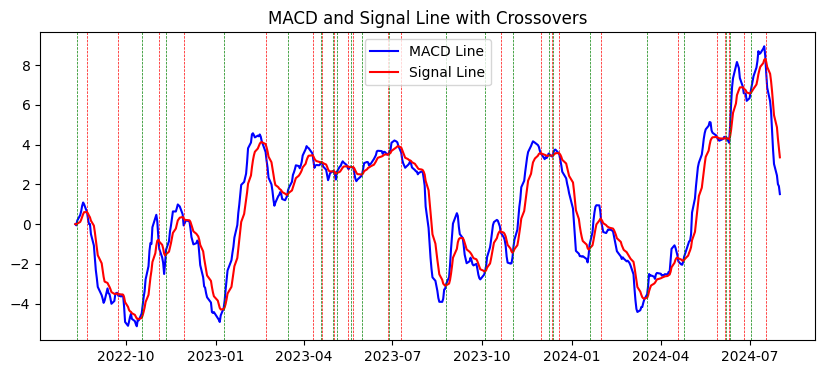

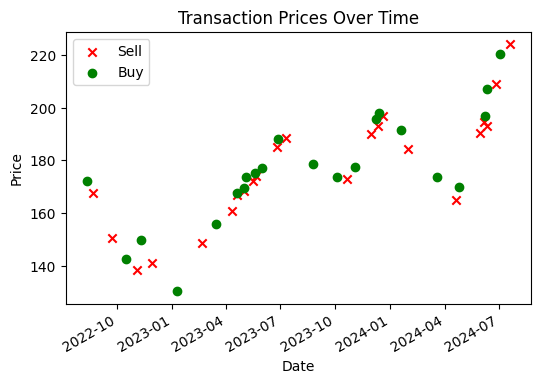

Running Simulation for MACD with AAPL from 2022-08-01 to 2024-08-01
Number of Transactions:  45
Buys:  22 Sells:  23
Open Price, Close Price:  169.24 218.36
Beginning Cash and Shares:  500000.0 2954.3843063105646
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 2689.02328339508
End Portfolio Value:  1137175.1241621496

Model Profit Percentage:  13.71751241621496
Market Change w/o trades 14.511935712597495

Model outperforms market by -0.7944232963825346 %


Invest RSI for MSFT from 2022-08-01 to 2024-08-01
Number of Data Points: 497


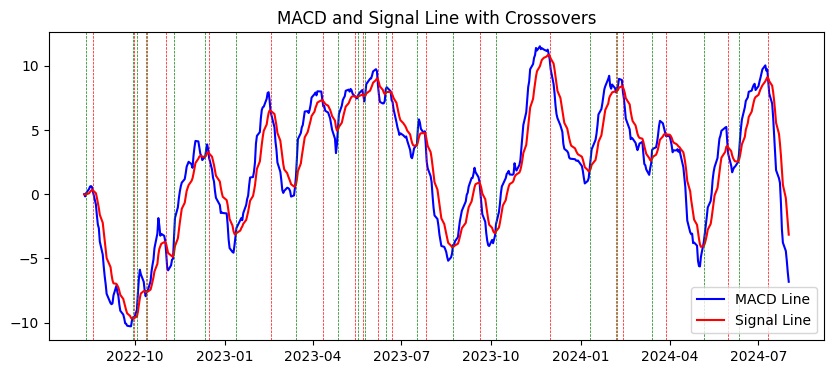

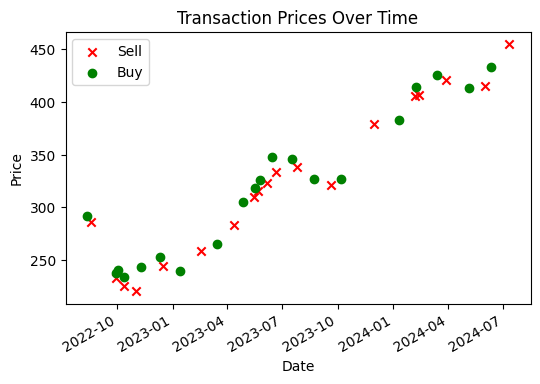

Running Simulation for MACD with MSFT from 2022-08-01 to 2024-08-01
Number of Transactions:  39
Buys:  20 Sells:  19
Open Price, Close Price:  289.16 417.11
Beginning Cash and Shares:  500000.0 1729.1464932909114
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  450000.0 1938.3667277279383
End Portfolio Value:  1258512.1458026003

Model Profit Percentage:  25.851214580260027
Market Change w/o trades 22.124429381657208

Model outperforms market by 3.726785198602819 %


Invest RSI for GOOGL from 2022-08-01 to 2024-08-01
Number of Data Points: 497


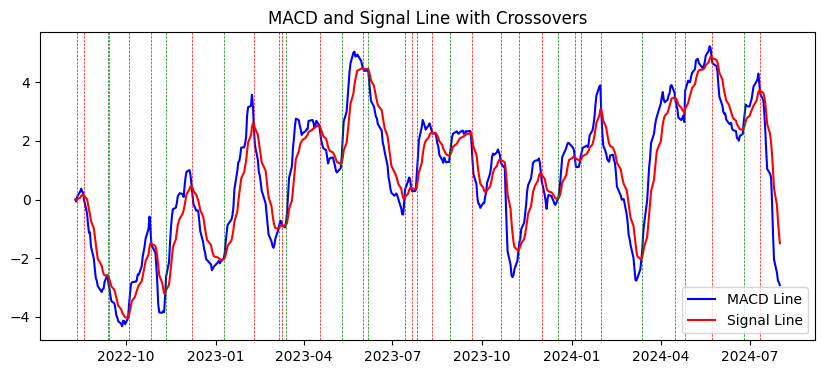

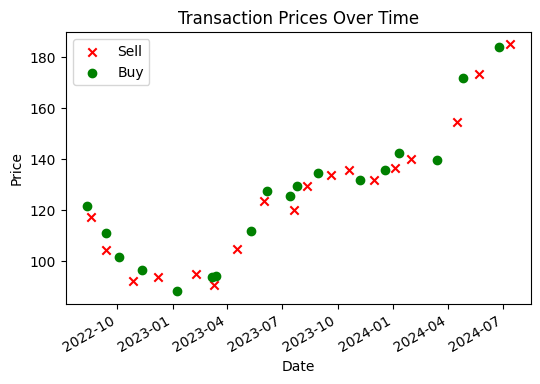

Running Simulation for MACD with GOOGL from 2022-08-01 to 2024-08-01
Number of Transactions:  36
Buys:  18 Sells:  18
Open Price, Close Price:  119.7 170.76
Beginning Cash and Shares:  500000.0 4177.109440267335
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 4226.551501022068
End Portfolio Value:  1221725.9343145282

Model Profit Percentage:  22.172593431452825
Market Change w/o trades 21.328320802005006

Model outperforms market by 0.8442726294478184 %


Invest RSI for GOOG from 2022-08-01 to 2024-08-01
Number of Data Points: 497


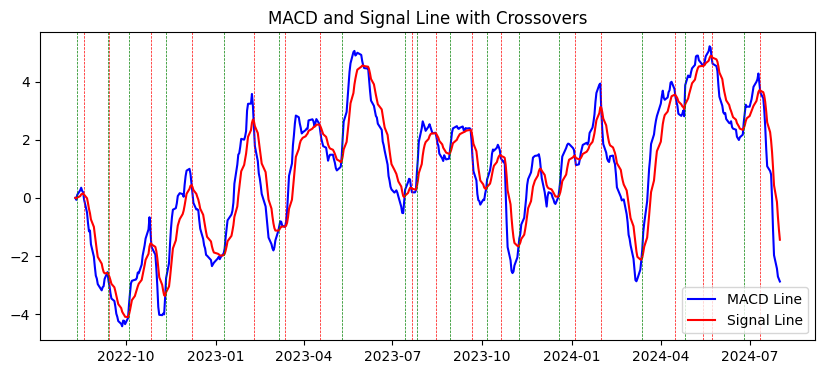

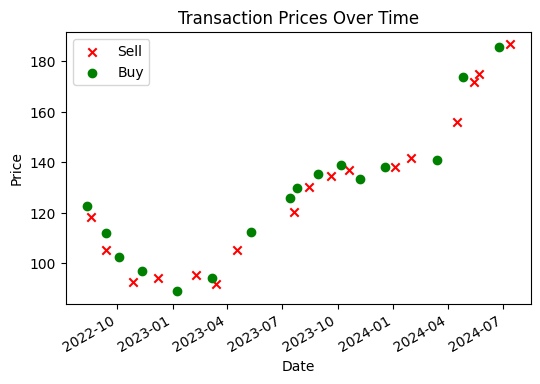

Running Simulation for MACD with GOOG from 2022-08-01 to 2024-08-01
Number of Transactions:  33
Buys:  16 Sells:  17
Open Price, Close Price:  120.65 172.45
Beginning Cash and Shares:  500000.0 4144.218814753419
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 3774.6932603067967
End Portfolio Value:  1200945.8527399069

Model Profit Percentage:  20.09458527399069
Market Change w/o trades 21.467053460422704

Model outperforms market by -1.372468186432016 %


Invest RSI for AMZN from 2022-08-01 to 2024-08-01
Number of Data Points: 497


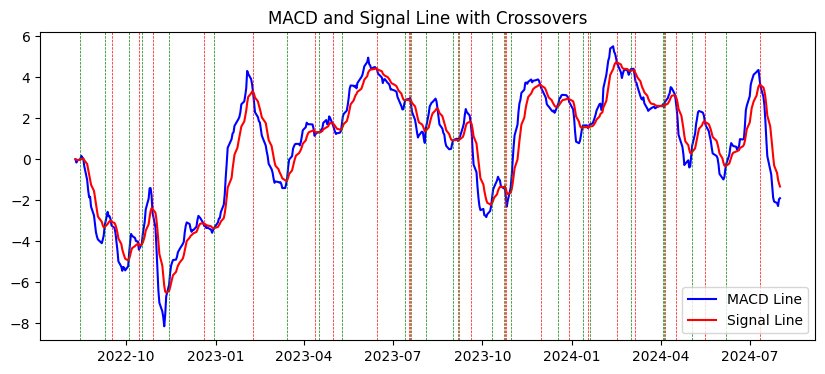

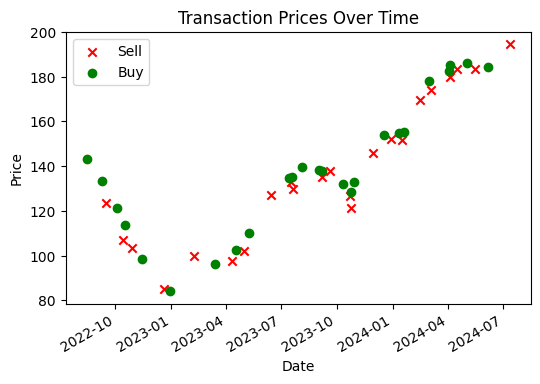

Running Simulation for MACD with AMZN from 2022-08-01 to 2024-08-01
Number of Transactions:  48
Buys:  25 Sells:  23
Open Price, Close Price:  142.69 184.07
Beginning Cash and Shares:  500000.0 3504.099796762212
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  400000.0 4146.058223024862
End Portfolio Value:  1163164.9371121863

Model Profit Percentage:  16.316493711218634
Market Change w/o trades 14.499964959002032

Model outperforms market by 1.8165287522166018 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for TSLA from 2022-08-01 to 2024-08-01
Number of Data Points: 497


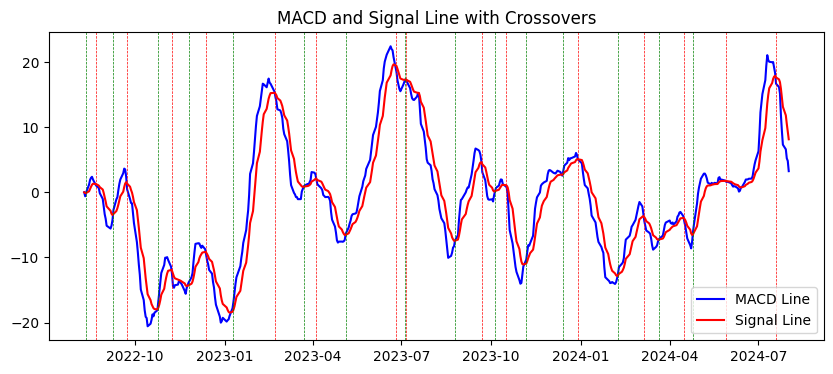

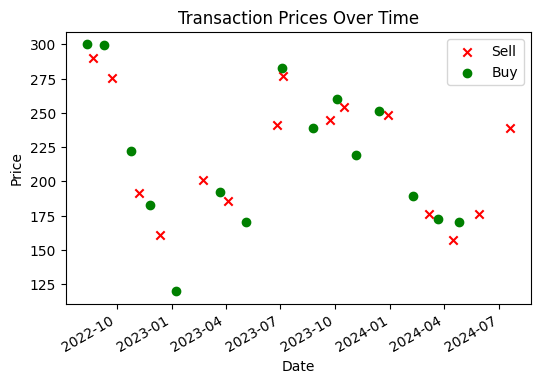

Running Simulation for MACD with TSLA from 2022-08-01 to 2024-08-01
Number of Transactions:  30
Buys:  15 Sells:  15
Open Price, Close Price:  294.3567 216.86
Beginning Cash and Shares:  500000.0 1698.6193961272159
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 1825.51005157909
End Portfolio Value:  895880.1097854415

Model Profit Percentage:  -10.411989021455845
Market Change w/o trades -13.163739775585197

Model outperforms market by 2.751750754129352 %


Invest RSI for NVDA from 2022-08-01 to 2024-08-01
Number of Data Points: 497


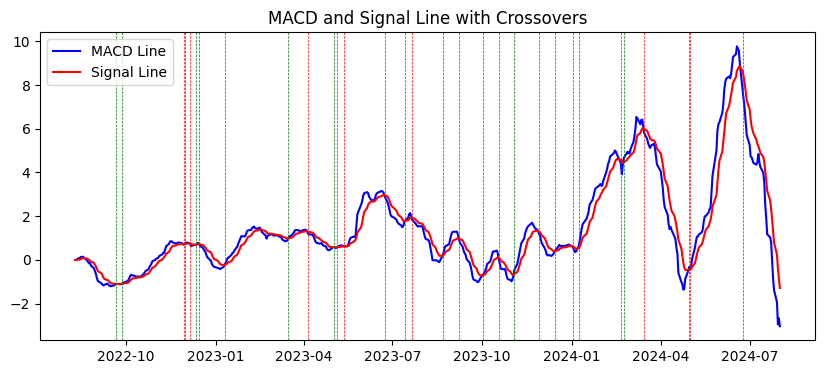

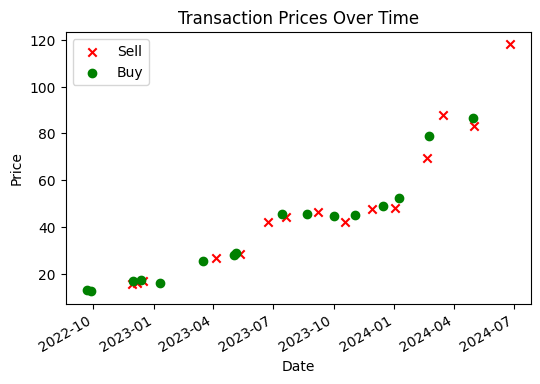

Running Simulation for MACD with NVDA from 2022-08-01 to 2024-08-01
Number of Transactions:  31
Buys:  16 Sells:  15
Open Price, Close Price:  18.097 109.21
Beginning Cash and Shares:  500000.0 27628.888766093827
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  450000.0 35588.3735433823
End Portfolio Value:  4336606.274672781

Model Profit Percentage:  333.6606274672781
Market Change w/o trades 251.73509421451067

Model outperforms market by 81.92553325276745 %


Invest RSI for BRK.B from 2022-08-01 to 2024-08-01
Number of Data Points: 497


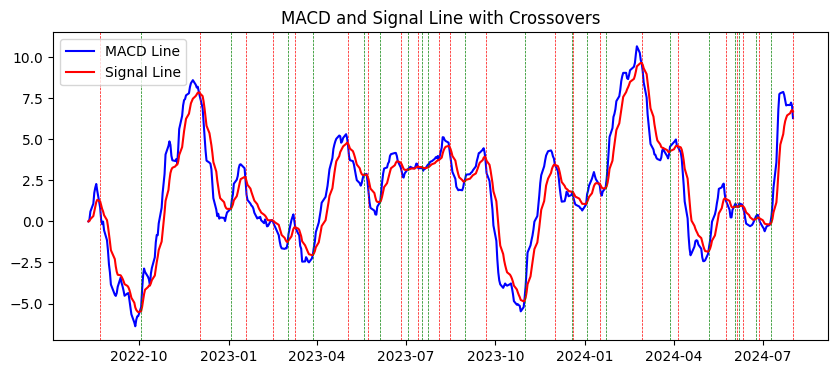

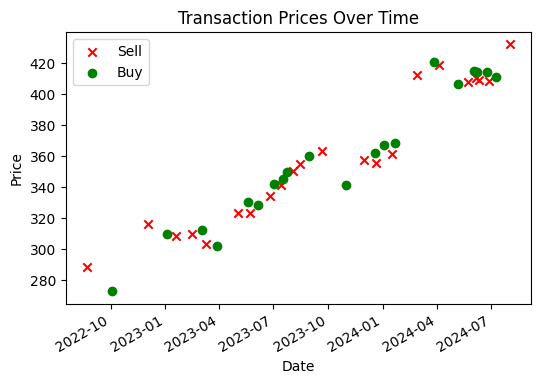

Running Simulation for MACD with BRK.B from 2022-08-01 to 2024-08-01
Number of Transactions:  42
Buys:  20 Sells:  22
Open Price, Close Price:  295.11 431.81
Beginning Cash and Shares:  500000.0 1694.2834875131307
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  600000.0 1411.1393242702916
End Portfolio Value:  1209344.0716131546

Model Profit Percentage:  20.93440716131546
Market Change w/o trades 23.160855274304495

Model outperforms market by -2.2264481129890363 %


Invest RSI for META from 2022-08-01 to 2024-08-01
Number of Data Points: 497


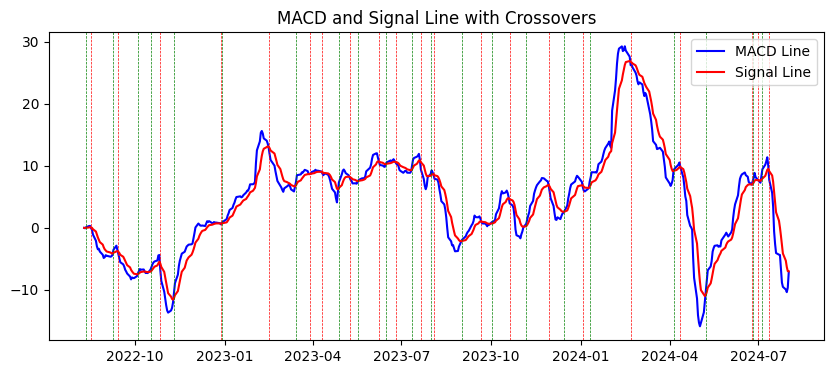

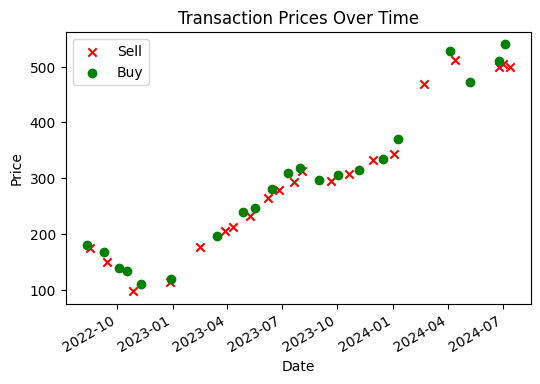

Running Simulation for MACD with META from 2022-08-01 to 2024-08-01
Number of Transactions:  42
Buys:  21 Sells:  21
Open Price, Close Price:  178.34 497.74
Beginning Cash and Shares:  500000.0 2803.6335090277
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 2931.574540153601
End Portfolio Value:  1959161.9116160534

Model Profit Percentage:  95.91619116160534
Market Change w/o trades 89.54805427834474

Model outperforms market by 6.368136883260604 %


Invest RSI for UNH from 2022-08-01 to 2024-08-01
Number of Data Points: 497


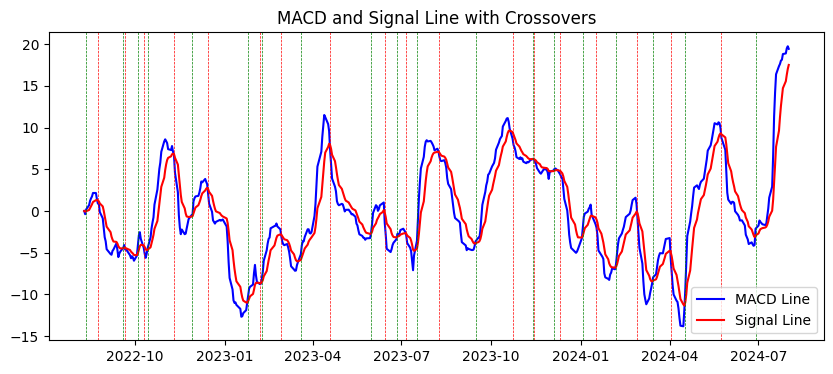

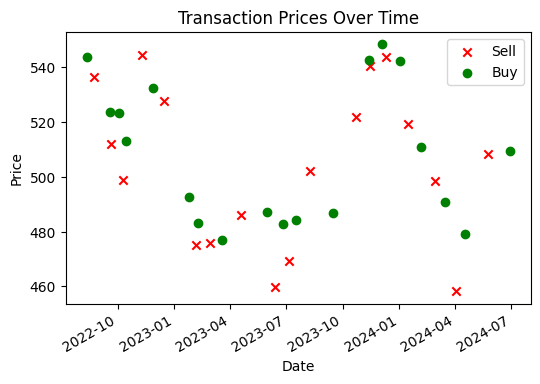

Running Simulation for MACD with UNH from 2022-08-01 to 2024-08-01
Number of Transactions:  37
Buys:  19 Sells:  18
Open Price, Close Price:  537.72 572.77
Beginning Cash and Shares:  500000.0 929.8519675667633
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  450000.0 1014.1088635786399
End Portfolio Value:  1030851.1337919376

Model Profit Percentage:  3.085113379193761
Market Change w/o trades 3.259131146321501

Model outperforms market by -0.1740177671277401 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for JNJ from 2022-08-01 to 2024-08-01
Number of Data Points: 497


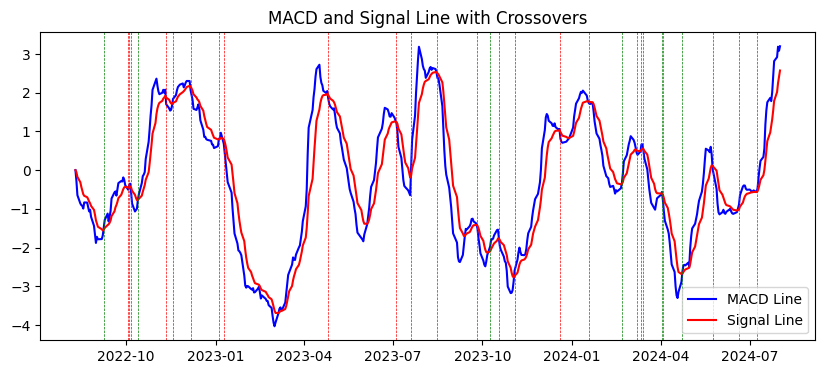

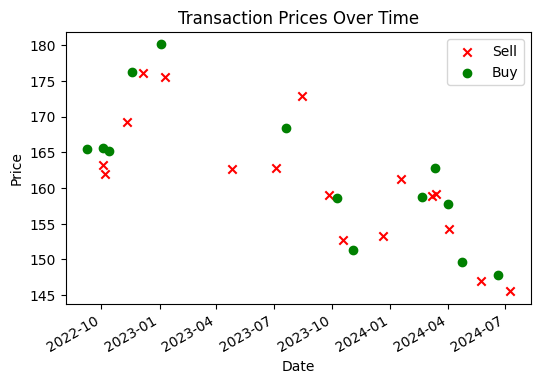

Running Simulation for MACD with JNJ from 2022-08-01 to 2024-08-01
Number of Transactions:  30
Buys:  13 Sells:  17
Open Price, Close Price:  170.67 160.76
Beginning Cash and Shares:  500000.0 2929.630280658581
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  700000.0 1654.6698032237066
End Portfolio Value:  966004.7175662431

Model Profit Percentage:  -3.399528243375686
Market Change w/o trades -2.9032636081326526

Model outperforms market by -0.4962646352430333 %


Invest RSI for V from 2022-08-01 to 2024-08-01
Number of Data Points: 497


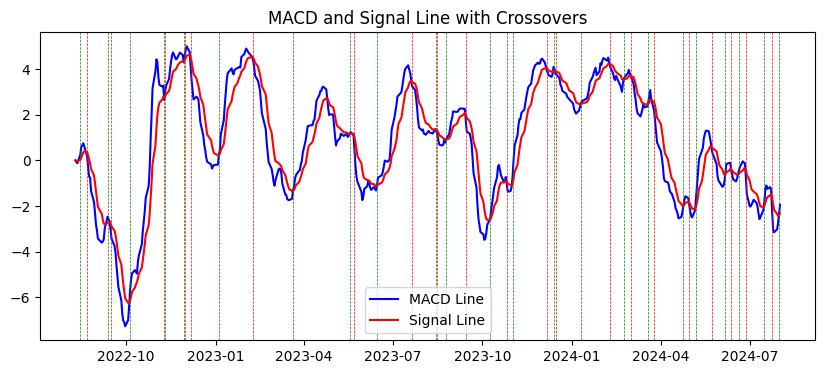

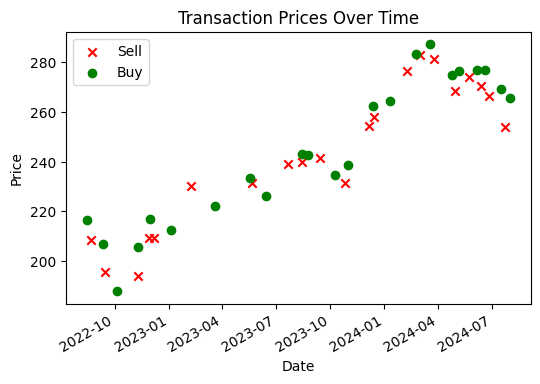

Running Simulation for MACD with V from 2022-08-01 to 2024-08-01
Number of Transactions:  44
Buys:  23 Sells:  21
Open Price, Close Price:  212.1 265.93
Beginning Cash and Shares:  500000.0 2357.3785950023575
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  400000.0 2759.1737994776067
End Portfolio Value:  1133747.08849508

Model Profit Percentage:  13.374708849507988
Market Change w/o trades 12.689768976897694

Model outperforms market by 0.6849398726102933 %


Invest RSI for WMT from 2022-08-01 to 2024-08-01
Number of Data Points: 497


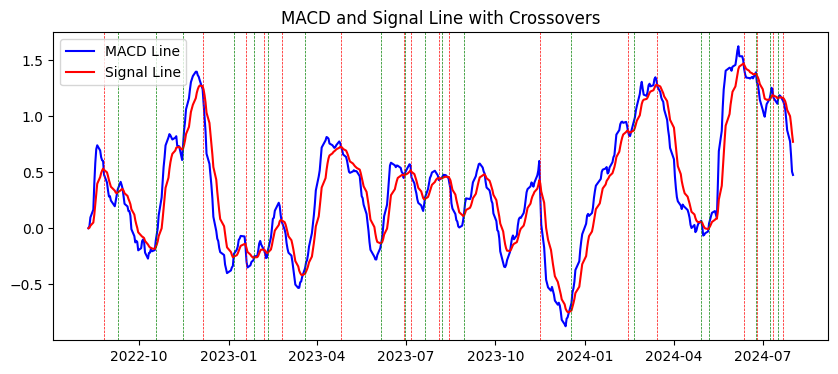

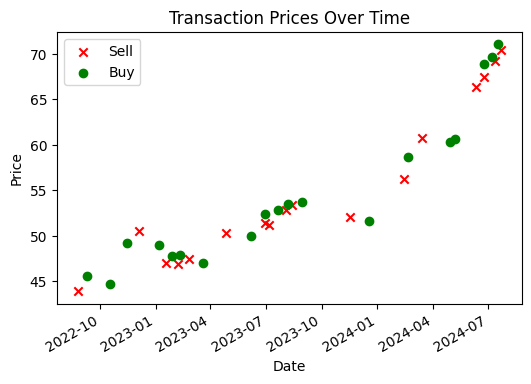

Running Simulation for MACD with WMT from 2022-08-01 to 2024-08-01
Number of Transactions:  36
Buys:  19 Sells:  17
Open Price, Close Price:  43.0467 69.79
Beginning Cash and Shares:  500000.0 11615.292229137192
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  400000.0 13670.441642017711
End Portfolio Value:  1354060.1221964161

Model Profit Percentage:  35.40601221964161
Market Change w/o trades 31.063124467148473

Model outperforms market by 4.342887752493137 %


Invest RSI for XOM from 2022-08-01 to 2024-08-01
Number of Data Points: 497


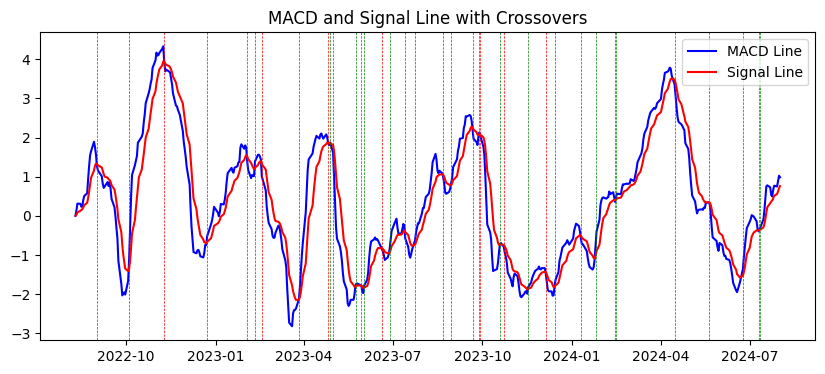

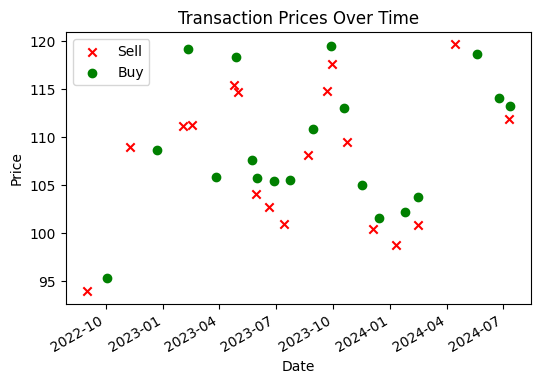

Running Simulation for MACD with XOM from 2022-08-01 to 2024-08-01
Number of Transactions:  37
Buys:  19 Sells:  18
Open Price, Close Price:  91.45 116.95
Beginning Cash and Shares:  500000.0 5467.468562055768
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  450000.0 5838.167194768382
End Portfolio Value:  1132773.6534281622

Model Profit Percentage:  13.277365342816221
Market Change w/o trades 13.942044833242209

Model outperforms market by -0.6646794904259874 %


Invest RSI for PG from 2022-08-01 to 2024-08-01
Number of Data Points: 497


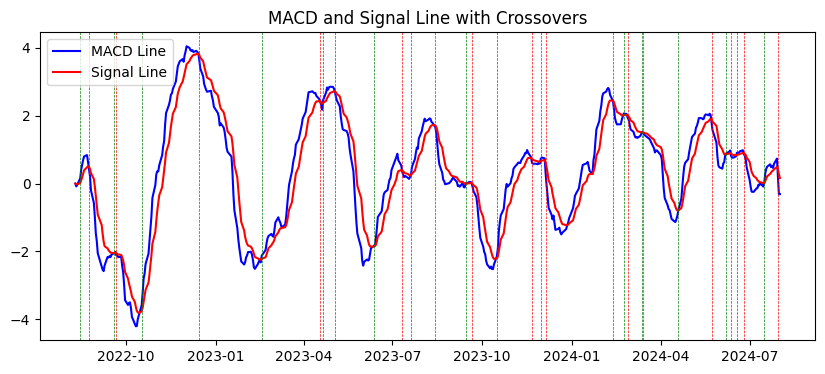

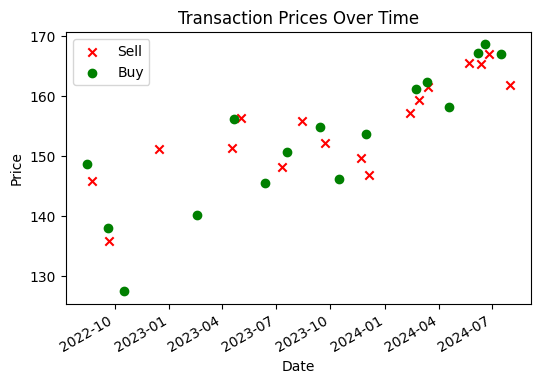

Running Simulation for MACD with PG from 2022-08-01 to 2024-08-01
Number of Transactions:  33
Buys:  16 Sells:  17
Open Price, Close Price:  146.3 165.69
Beginning Cash and Shares:  500000.0 3417.6349965823647
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 3173.4091979743375
End Portfolio Value:  1075802.170012368

Model Profit Percentage:  7.580217001236789
Market Change w/o trades 6.6267942583732005

Model outperforms market by 0.9534227428635882 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for JPM from 2022-08-01 to 2024-08-01
Number of Data Points: 497


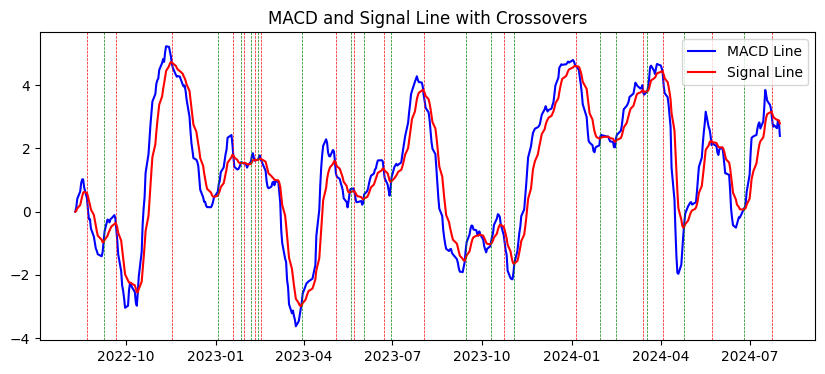

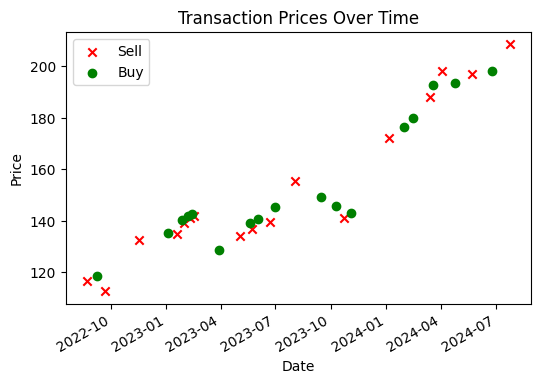

Running Simulation for MACD with JPM from 2022-08-01 to 2024-08-01
Number of Transactions:  34
Buys:  17 Sells:  17
Open Price, Close Price:  118.39 207.96
Beginning Cash and Shares:  500000.0 4223.329673114284
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 4118.515841040092
End Portfolio Value:  1356486.5543026975

Model Profit Percentage:  35.648655430269756
Market Change w/o trades 37.82836388208464

Model outperforms market by -2.179708451814882 %


Invest RSI for MA from 2022-08-01 to 2024-08-01
Number of Data Points: 497


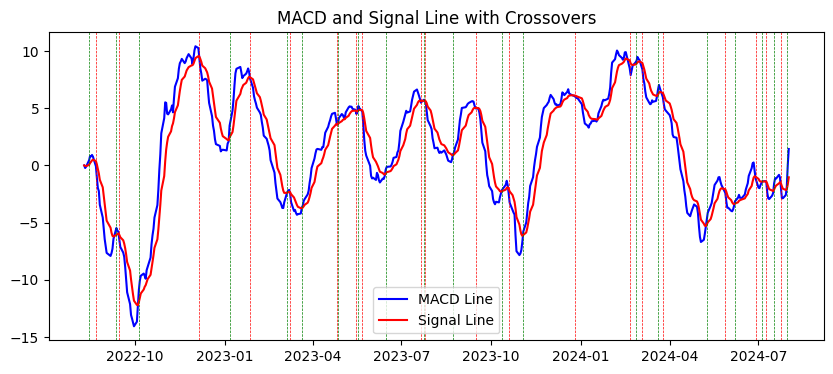

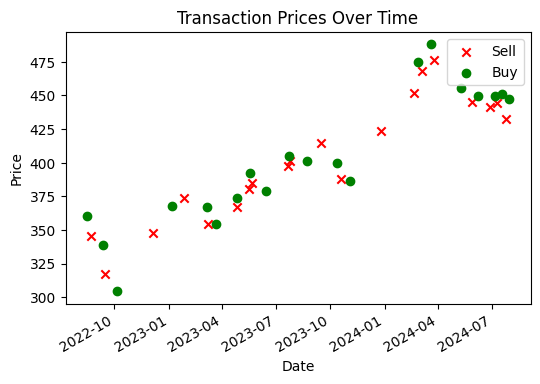

Running Simulation for MACD with MA from 2022-08-01 to 2024-08-01
Number of Transactions:  40
Buys:  20 Sells:  20
Open Price, Close Price:  353.38 462.41
Beginning Cash and Shares:  500000.0 1414.9074650517857
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 1424.661143011221
End Portfolio Value:  1158777.5591398187

Model Profit Percentage:  15.877755913981865
Market Change w/o trades 15.426736091459626

Model outperforms market by 0.45101982252223927 %


Invest RSI for LLY from 2022-08-01 to 2024-08-01
Number of Data Points: 497


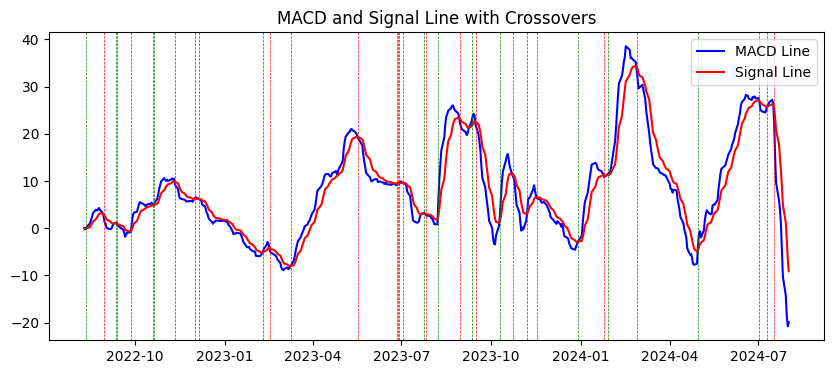

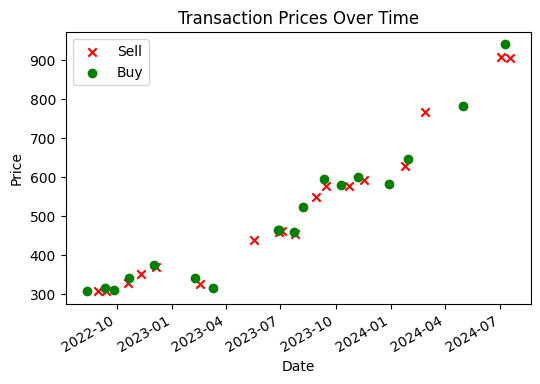

Running Simulation for MACD with LLY from 2022-08-01 to 2024-08-01
Number of Transactions:  36
Buys:  18 Sells:  18
Open Price, Close Price:  304.61 832.44
Beginning Cash and Shares:  500000.0 1641.443156823479
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 1707.0143630581358
End Portfolio Value:  1920987.0363841148

Model Profit Percentage:  92.09870363841148
Market Change w/o trades 86.64029414661371

Model outperforms market by 5.458409491797767 %


Invest RSI for HD from 2022-08-01 to 2024-08-01
Number of Data Points: 497


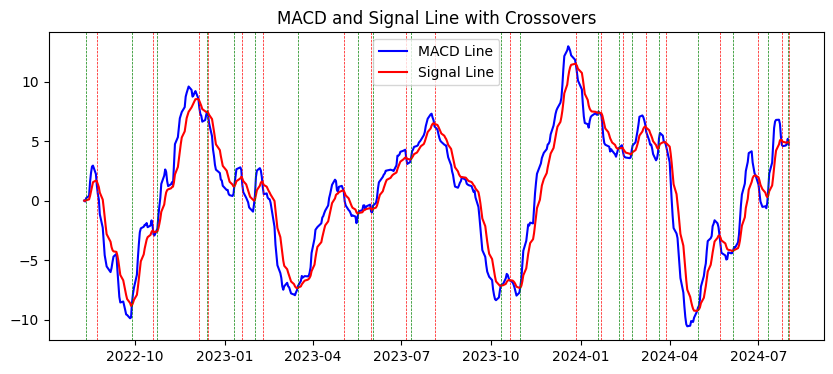

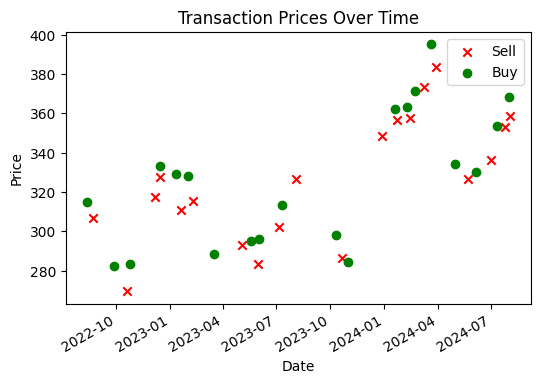

Running Simulation for MACD with HD from 2022-08-01 to 2024-08-01
Number of Transactions:  40
Buys:  20 Sells:  20
Open Price, Close Price:  311.58 358.58
Beginning Cash and Shares:  500000.0 1604.7243083638232
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 1612.4466336539267
End Portfolio Value:  1078191.1138956249

Model Profit Percentage:  7.8191113895624875
Market Change w/o trades 7.54220424930997

Model outperforms market by 0.2769071402525176 %


Invest RSI for CVX from 2022-08-01 to 2024-08-01
Number of Data Points: 497


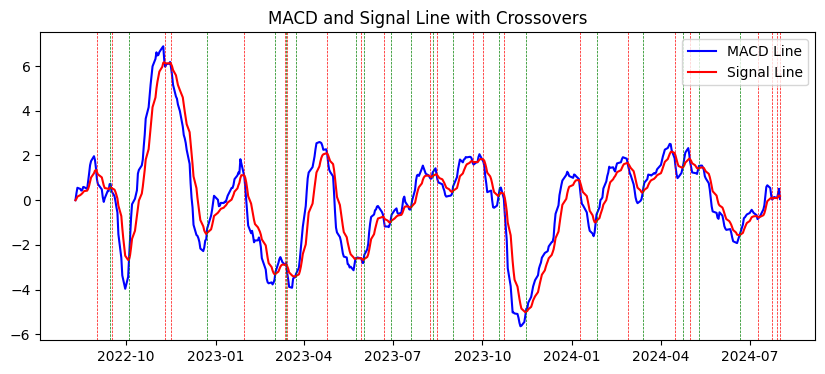

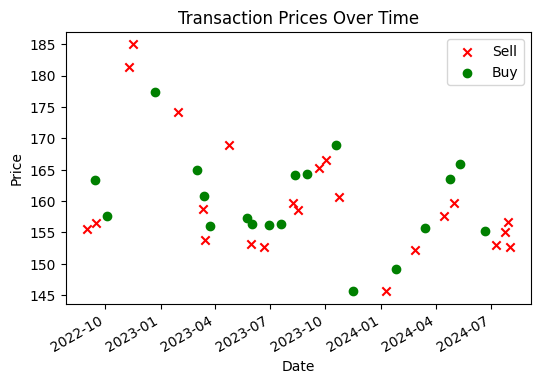

Running Simulation for MACD with CVX from 2022-08-01 to 2024-08-01
Number of Transactions:  42
Buys:  19 Sells:  23
Open Price, Close Price:  155.82 152.62
Beginning Cash and Shares:  500000.0 3208.830702092158
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  700000.0 1955.0795434821262
End Portfolio Value:  998384.239926242

Model Profit Percentage:  -0.16157600737579633
Market Change w/o trades -1.026825824669487

Model outperforms market by 0.8652498172936907 %


Waiting for 60 seconds to avoid rate limit
Invest RSI for MRK from 2022-08-01 to 2024-08-01
Number of Data Points: 497


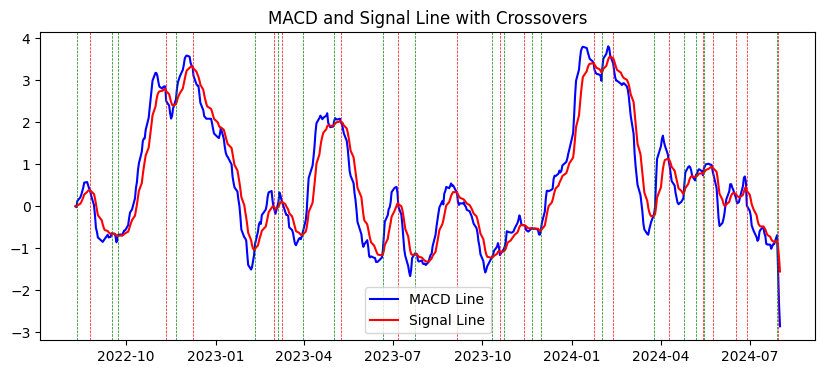

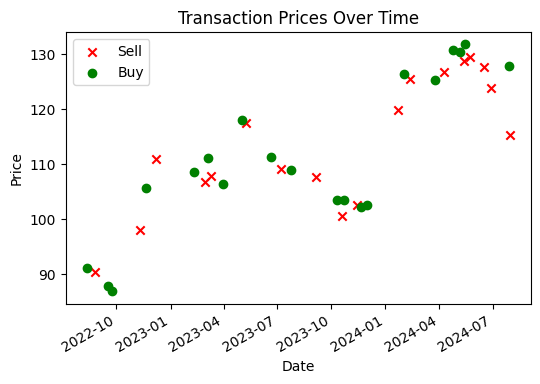

Running Simulation for MACD with MRK from 2022-08-01 to 2024-08-01
Number of Transactions:  38
Buys:  20 Sells:  18
Open Price, Close Price:  89.19 113.82
Beginning Cash and Shares:  500000.0 5606.009642336585
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  400000.0 6765.443577309106
End Portfolio Value:  1170042.7879693224

Model Profit Percentage:  17.00427879693224
Market Change w/o trades 13.807601749075008

Model outperforms market by 3.196677047857232 %


Invest RSI for PEP from 2022-08-01 to 2024-08-01
Number of Data Points: 497


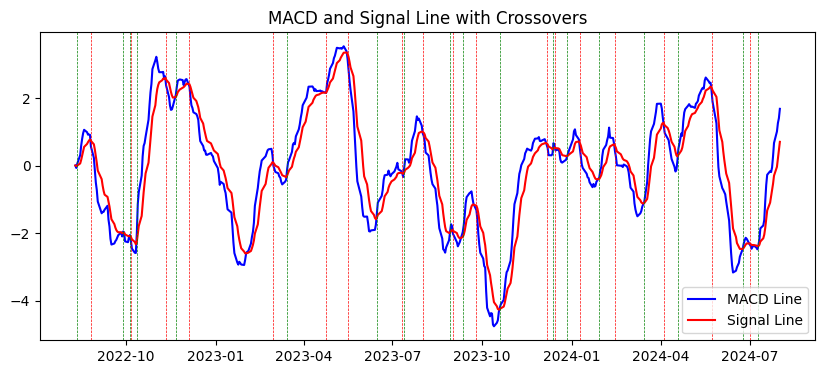

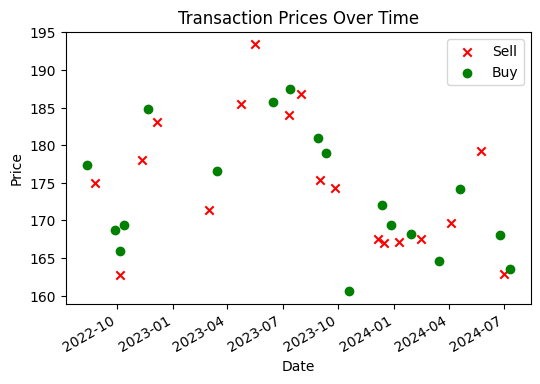

Running Simulation for MACD with PEP from 2022-08-01 to 2024-08-01
Number of Transactions:  36
Buys:  18 Sells:  18
Open Price, Close Price:  175.94 174.96
Beginning Cash and Shares:  500000.0 2841.877912924861
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 2896.4721889282046
End Portfolio Value:  1006766.7741748786

Model Profit Percentage:  0.6766774174878607
Market Change w/o trades -0.2785040354666335

Model outperforms market by 0.9551814529544942 %


Invest RSI for ABBV from 2022-08-01 to 2024-08-01
Number of Data Points: 497


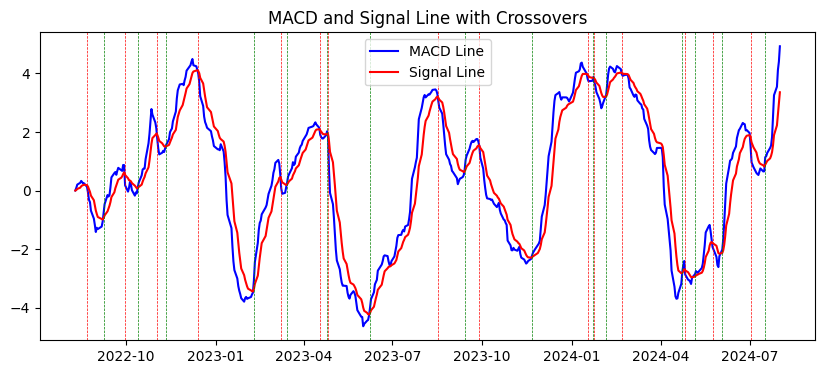

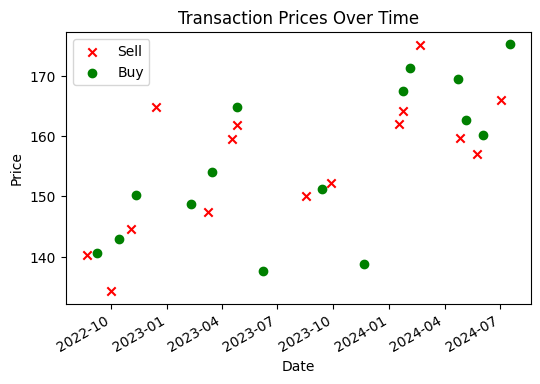

Running Simulation for MACD with ABBV from 2022-08-01 to 2024-08-01
Number of Transactions:  30
Buys:  15 Sells:  15
Open Price, Close Price:  140.94 189.71
Beginning Cash and Shares:  500000.0 3547.608911593586
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  500000.0 3561.9252002533194
End Portfolio Value:  1175732.8297400572

Model Profit Percentage:  17.573282974005725
Market Change w/o trades 17.301688661841926

Model outperforms market by 0.27159431216379915 %


Invest RSI for KO from 2022-08-01 to 2024-08-01
Number of Data Points: 497


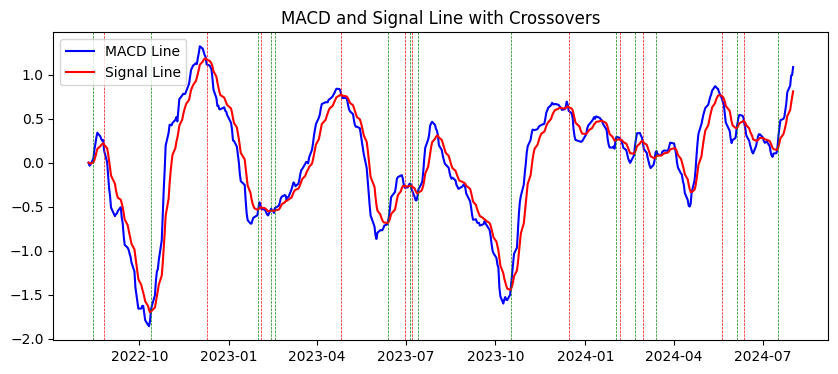

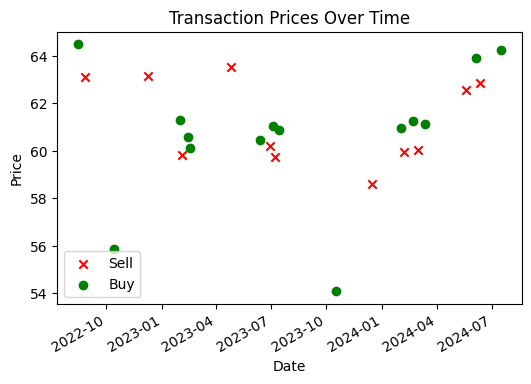

Running Simulation for MACD with KO from 2022-08-01 to 2024-08-01
Number of Transactions:  25
Buys:  14 Sells:  11
Open Price, Close Price:  63.65 67.96
Beginning Cash and Shares:  500000.0 7855.459544383347
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  350000.0 10416.192277840319
End Portfolio Value:  1057884.427202028

Model Profit Percentage:  5.788442720202799
Market Change w/o trades 3.3857030636292182

Model outperforms market by 2.4027396565735804 %


Invest RSI for SPY from 2022-08-01 to 2024-08-01
Number of Data Points: 497


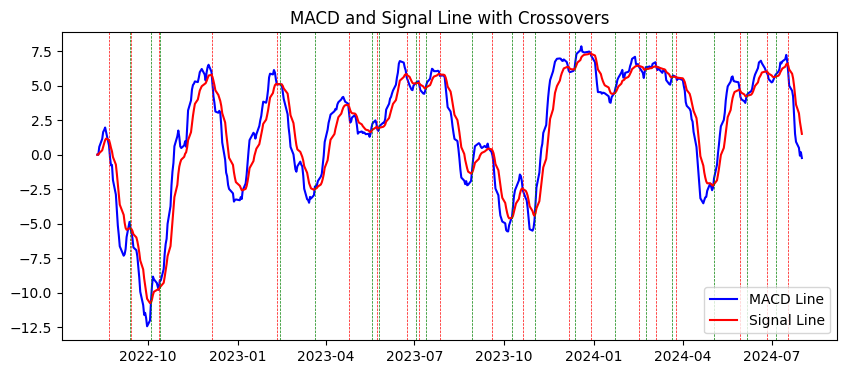

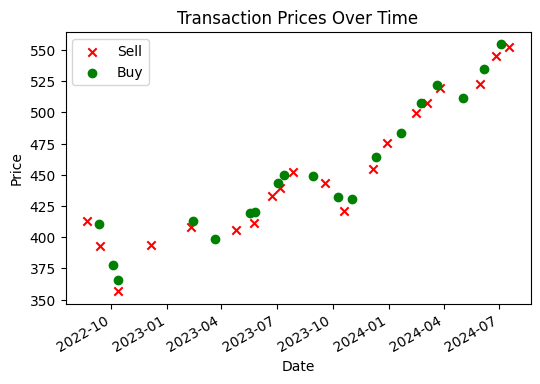

Running Simulation for MACD with SPY from 2022-08-01 to 2024-08-01
Number of Transactions:  39
Buys:  19 Sells:  20
Open Price, Close Price:  419.99 543.01
Beginning Cash and Shares:  500000.0 1190.5045358222815
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  550000.0 1078.082380452563
End Portfolio Value:  1135409.513409546

Model Profit Percentage:  13.54095134095461
Market Change w/o trades 14.645586799685702

Model outperforms market by -1.1046354587310923 %


Alphas for each stock: {'AAPL': -0.7944232963825346, 'MSFT': 3.726785198602819, 'GOOGL': 0.8442726294478184, 'GOOG': -1.372468186432016, 'AMZN': 1.8165287522166018, 'TSLA': 2.751750754129352, 'NVDA': 81.92553325276745, 'BRK.B': -2.2264481129890363, 'META': 6.368136883260604, 'UNH': -0.1740177671277401, 'JNJ': -0.4962646352430333, 'V': 0.6849398726102933, 'WMT': 4.342887752493137, 'XOM': -0.6646794904259874, 'PG': 0.9534227428635882, 'JPM': -2.179708451814882, 'MA': 0.45101982252223927, 'LLY': 5.458409491797767, 'H

In [219]:
#test
# tickers = ["AMD", "ARM", "ARM", "ABNB", "NVDA"]
tickers = top_25_tickers
start_date = "2022-08-01"
end_date =  "2024-08-01"
initial_portfolio_value = 1000000
count = 0

for ticker in tickers:
    if count % 5 == 0 and count != 0:
        print("Waiting for 60 seconds to avoid rate limit")
        time.sleep(60)
    count += 1
        

    print("Invest RSI for", ticker, "from" , start_date, "to" , end_date)
    
    data = get_data(ticker, start_date, end_date)
    # replace start price with start price of stock (you can find it in yahoo finance)
    start_price = data[0].close
   
    initial_cash = 0.5 * initial_portfolio_value
    initial_shares = (0.5 * initial_portfolio_value/start_price) if start_price > 0 else 1000
    percent_invest = 10
    alpha, profit = test_model(ticker, data, start_date, end_date, initial_cash, initial_shares, percent_invest) # can only run for about 1.5 yrs
    alphas_dict[ticker] = alpha
    print()
    print()
    

print("Alphas for each stock:", alphas_dict)


Average Alpha:  4.331175647226427


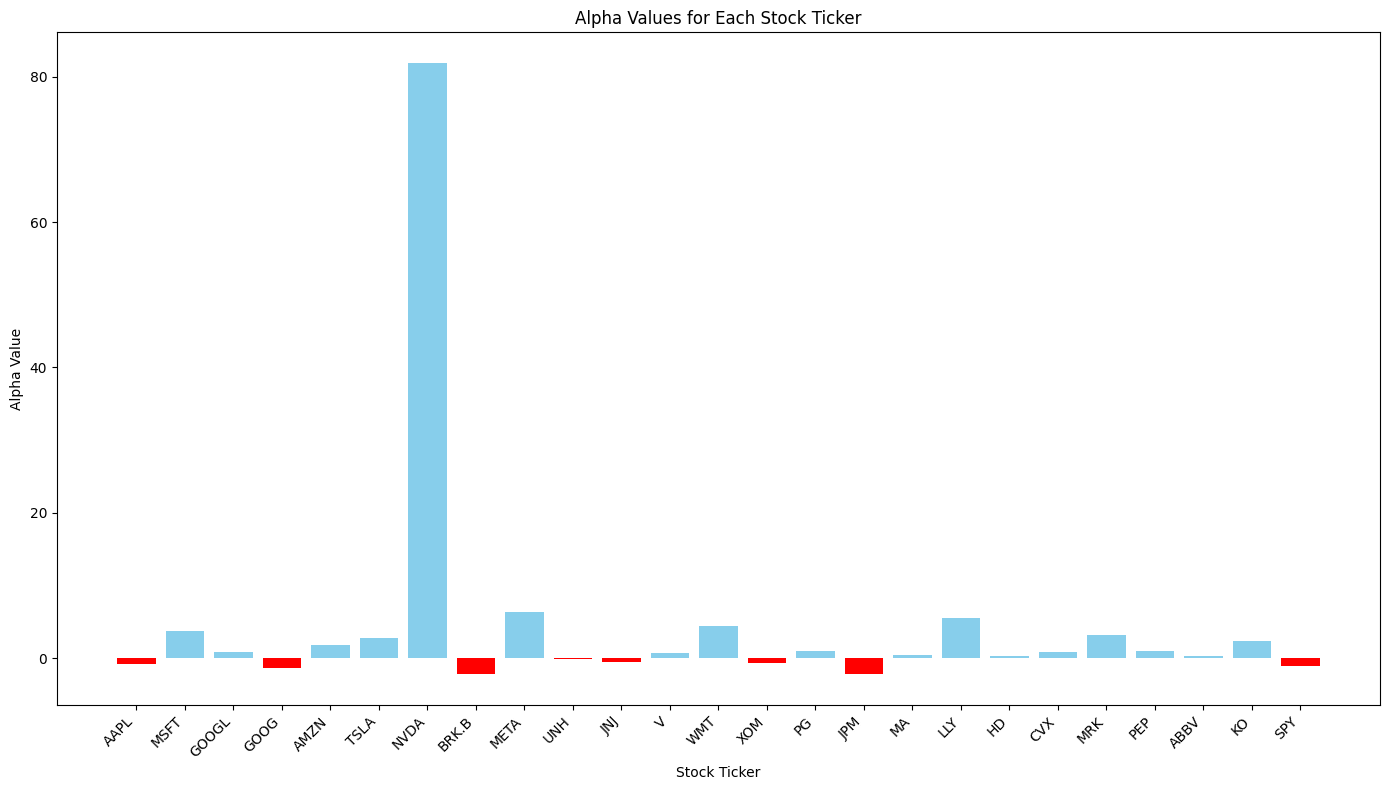

In [220]:
# Create lists of tickers and corresponding alphas
tickers = list(alphas_dict.keys())
alphas = list(alphas_dict.values())
print("Average Alpha: ", sum(alphas)/len(alphas))

colors = ['red' if alpha < 0 else 'skyblue' for alpha in alphas]  # Red for negative, blue for positive

# Plotting the data
plt.figure(figsize=(14, 8))
plt.bar(tickers, alphas, color=colors)

# Labels and title
plt.xlabel('Stock Ticker')
plt.ylabel('Alpha Value')
plt.title('Alpha Values for Each Stock Ticker')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')


# Show the plot
plt.tight_layout()
plt.show()